# PRÀCTICA 3: EXTRACCIÓ D'ENTITATS ANOMENADES

Irene Pumares Benaiges i Anna Casanovas Poirier

Grau en Intel·ligència Artificial

Processament del Llenguatge Humà

Importem totes les coses necessàries

In [ ]:
pip install python-crfsuite

In [ ]:
import nltk
nltk.download('conll2002')

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tag import CRFTagger
import pandas as pd
from nltk.corpus import conll2002
from collections import defaultdict
import pycrfsuite

from typing import Optional, List, Tuple, Dict, Any
from typing import List, Tuple, Optional, Callable
from nltk.tag import CRFTagger

def download_nltk_resources():
    resources = ['averaged_perceptron_tagger', 'wordnet', 'omw-1.4']
    for resource in resources:
        nltk.download(resource)

download_nltk_resources()

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from typing import List

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Creem una classe que conté tots els mètodes necessaris per a entrenar, predir i evaluar el nostre model de reconeixement d'entitats

In [ ]:
class CRFModel:
    def __init__(self, train, test, model_file: Optional[str] = None, features: Optional[Callable] = None, encoding: str = 'bio') -> None:
        """
        Inicialitza el model CRF amb les configuracions opcionals.
        - model_file: Nom de l'archiu on es guarda/carrega el model.
        - features: Funció de característiques personalitzades pel CRFTagger.
        - encoding: Esquema de codificació per les etiquetes (ej. 'bio', 'io').
        """

        self.model = CRFTagger(feature_func=features)
        self.model_file = model_file
        self.encoding = encoding

        self.train_data = self.transformar_dades(train)
        self.test_data = self.transformar_dades(test)

    def transformar_dades(self, data):
        """
        Les dades originals estan en un format bio, així que el
        mètode s'encarrega de codificar les dades amb el encoding escollit
        """
        if self.encoding == 'io':
            data_encoded = [self.to_io(sent) for sent in data]
        elif self.encoding == 'bioes':
            data_encoded = [self.to_bioes(sent) for sent in data]
        else:
            data_encoded = data
        return data_encoded

    def train(self, train_data: List[List[Tuple[str, str]]]) -> None:
        """
        Entrena el model amb les dades del train
        """
        self.model.train(train_data, self.model_file)

    def predict(self, sents: List[List[Tuple[str, str]]]) -> List[List[Tuple[str, str]]]:
        """
        Prediu les etiquetes per les frases donades
        """
        if self.model_file:
            self.model.set_model_file(self.model_file)

        words_test = [[word for (word, _) in sent] for sent in sents]
        return self.model.tag_sents(words_test)

    def to_bioes(self, bio_tags):
        """
        Passa les dades de una codificació BIO a una BIOES
        """
        bioes_tags = []
        for i, (word, tag) in enumerate(bio_tags):
            if tag == 'O':
                bioes_tags.append((word, tag))
            elif tag.startswith('B-'):
                if i + 1 < len(bio_tags) and bio_tags[i + 1][1].startswith('I-'):
                    bioes_tags.append((word, tag))
                else:
                    bioes_tags.append((word, tag.replace('B-', 'S-')))
            elif tag.startswith('I-'):
                if i + 1 < len(bio_tags) and bio_tags[i + 1][1].startswith('I-'):
                    bioes_tags.append((word, tag))
                else:
                    bioes_tags.append((word, tag.replace('I-', 'E-')))
        return bioes_tags

    def to_io(self, bio_tags):
        """
        Converteix les etiquetes de BIO a IO
        """
        io_tags = []
        for word, tag in bio_tags:
            if 'B-' in tag or 'I-' in tag:
                io_tags.append((word, 'I-' + tag.split('-')[1]))
            else:
                io_tags.append((word, 'O'))
        return io_tags

    def extraccio_entitats(self, tagged_sents: List[List[Tuple[str, str]]]) -> List[Tuple[int, int, str]]:
        """
        A partir de les frases ja etiquetades, s'extreuen les entitats.
        Retorna una tupla de l'index de començament i de final de l'entitat i el tipus
        """
        entities = []
        global_index = 0
        current_entity = None
        if self.encoding == 'io':
            entities = []
            global_index = 0
            current_entity = None
            for sent in tagged_sents:
                for (word, tag) in sent:
                    if 'I-' in tag:
                        if current_entity is None:
                            current_entity = (global_index, global_index, tag[2:])
                        else:
                            if current_entity[2] != tag[2:]:
                              entities.append(current_entity)
                              current_entity = (global_index, global_index, tag[2:])
                            else:
                              current_entity = (current_entity[0], global_index, tag[2:])
                    else:
                        if current_entity:
                          entities.append(current_entity)
                          current_entity = None

                    global_index += 1

                if current_entity:
                    entities.append(current_entity)
                    current_entity = None

        elif self.encoding == 'bioes':
            entities = []
            global_index = 0
            current_entity = None
            for sent in tagged_sents:
              for (word, tag) in sent:
                if 'S-' in tag:
                  entities.append((global_index, global_index, tag[2:]))
                elif 'B-' in tag:
                  current_entity = (global_index, global_index, tag[2:])
                elif 'I-' in tag:
                  current_entity = (current_entity[0], global_index, current_entity[2])
                elif 'E' in tag:
                  entities.append((current_entity[0], global_index, current_entity[2]))
                global_index += 1

        else:
            entities = []
            global_index = 0
            current_entity = None
            for sent in tagged_sents:
                for (word, tag) in sent:
                    if 'B-' in tag:
                        if current_entity is not None:
                            entities.append(current_entity)
                        current_entity = (global_index, global_index, tag[2:])
                    elif 'I-' in tag and current_entity:
                        current_entity = (current_entity[0], global_index, current_entity[2])
                    global_index += 1

                if current_entity:
                    entities.append(current_entity)
                    current_entity = None


        return entities

    def evaluacio_entitats(self, y_true, y_pred) -> Tuple[float, float, float]:
        """
        Calcula les mètriques d'avaluació del model
        """
        true_set = set(y_true)
        predicted_set = set(y_pred)
        TP = len(true_set & predicted_set)
        FP = len(predicted_set - true_set)
        FN = len(true_set - predicted_set)
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        #Calculem també la matriu de confusió
        self.matriu_confusio(y_true, y_pred)

        return recall, precision, f1

    def matriu_confusio(self, y_true, y_pred):
        """
        Calcula la matriu de confusió
        """
        all_entity_types = set(e[2] for e in y_true + y_pred)
        all_entity_types.add('None')

        confusion = {true: {pred: 0 for pred in all_entity_types} for true in all_entity_types}

        true_dict = {(te[0], te[1]): te[2] for te in y_true}
        for pe in y_pred:
            start, end, type_pred = pe
            true_type = true_dict.get((start, end), 'None')
            confusion[true_type][type_pred] += 1

        for te in y_true:
            start, end, type_true = te
            if (start, end) not in {(pe[0], pe[1]) for pe in y_pred}:
                confusion[type_true]['None'] += 1

        df = pd.DataFrame(confusion).fillna(0).astype(int)
        plt.figure(figsize=(10, 8))
        sns.heatmap(df.T, annot=True, fmt="d", cmap="Blues", xticklabels=df.index, yticklabels=df.columns)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()


Com a paràmetre de la nostra classe, es requereix una feature_function. Aquestes funcions són utilitzades per transformar el text en brut, a un format per aprendre i fer les prediccions, bàsicament extreuen atributs rellevants de les dades, com la paraula anterior, la seva informació morfosintàctica...

In [ ]:
def get_wordnet_pos(treebank_tag):
    """
    Funció que converteix les etiquetes POS de treebank a un format de WordNet per realitzar la lematització
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def creacio_feature_function(tokens, idx, feature_types):
    """
    Funció que crea la funció de característiques a partir de quines característiques
    creiem importants pel model

    feature_types donats és un diccionari de les possibles característiques i si les volem
    incluir o no (True o False)

    Retorna la llista de features dels tokens.
    """
    features = []
    features.append('bias')

    #POS TAGS
    if feature_types.get('lemma_pos_tags', True):
        tagged_tokens = nltk.pos_tag(tokens)
        token, pos_tag = tagged_tokens[idx]
        wn_pos = get_wordnet_pos(pos_tag)
        lemma = lemmatizer.lemmatize(token.lower(), wn_pos) if wn_pos else token.lower()
        features.append(f'lemma={lemma}')
        features.append(f'pos={pos_tag}')

    token = tokens[idx]

    #PARAULA
    if feature_types.get('word_form', True):
        features.extend([
            f'word={token}',
            f'token={token.lower()}'
        ])

    #PREFIXOS I SUFIXOS
    if feature_types.get('prefix_suffix', True):
        features.extend([
            f'prefix-1={token[0]}',
            f'prefix-2={token[:2]}',
            f'prefix-3={token[:3]}',
            f'suffix-1={token[-1]}',
            f'suffix-2={token[-2:]}',
            f'suffix-3={token[-3:]}'
        ])

    #MORFOLOGIA
    if feature_types.get('morphology', True):
        features.extend([
            f'is_capitalized={token[0].isupper()}',
            f'is_all_caps={token.isupper()}',
            f'is_all_lower={token.islower()}',
            f'has_hyphen={"-" in token}',
            f'is_numeric={token.isdigit()}',
            f'capitals_inside={token[1:].lower() != token[1:]}'
        ])

    #LLARGADA
    if feature_types.get('length', True):
        features.append(f'length={len(token)}')

    #POSICIÓ
    if feature_types.get('position', True):
        features.extend([
            f'is_first={idx==0}',
            f'is_last={idx ==len(tokens)-1}'
        ])

    #INFORMACIÓ DE LA PARAULA D'ABANS
    if idx > 0 and feature_types.get('context', True):
        prev_token = tokens[idx-1]
        features.extend([
            f'prev_token={prev_token.lower()}',
            f'prev_is_capitalized={prev_token[0].isupper()}',
            f'prev_is_all_caps={prev_token.isupper()}',
            f'prev_is_all_lower={prev_token.islower()}'
        ])

        if feature_types.get('lemma_pos_tags', True):
            prev_token, prev_pos_tag = tagged_tokens[idx - 1]
            prev_wn_pos = get_wordnet_pos(prev_pos_tag)
            prev_lemma = lemmatizer.lemmatize(prev_token.lower(), prev_wn_pos) if prev_wn_pos else prev_token.lower()
            features.extend([
                f'prev_lemma={prev_lemma}',
                f'prev_pos={prev_pos_tag}'
            ])

    #INFORMACIÓ DE LA PARAULA DE DESPRÉS
    if idx < len(tokens) - 1 and feature_types.get('context', True):
        if feature_types.get('lemma_pos_tags', True):
            next_token, next_pos_tag = tagged_tokens[idx + 1]
            next_wn_pos = get_wordnet_pos(next_pos_tag)
            next_lemma = lemmatizer.lemmatize(next_token.lower(), next_wn_pos) if next_wn_pos else next_token.lower()
            features.extend([
            f'next_lemma={next_lemma}',
            f'next_pos={next_pos_tag}'
        ])
        next_token = tokens[idx+1]
        features.extend([
            f'next_token={next_token.lower()}',
            f'next_is_capitalized={next_token[0].isupper()}',
            f'next_is_all_caps={next_token.isupper()}',
            f'next_is_all_lower={next_token.islower()}'
        ])

    return features


Un cop tenim la funció que ens crea la feature function, creem una que inicialitzi les funcions que voldrem

In [ ]:
def features_personalitzada(tokens, idx):
    """
    Funció que li proporcionarem a la classe del model
    Crea la nostra feature function a partir de
    les característiques decidides
    """
    feature_types = {
        'word_form': True,
        'lemma_pos_tags': False,
        'prefix_suffix': True,
        'morphology': True,
        'length': True,
        'position': True,
        'context': True
    }
    return creacio_feature_function(tokens, idx, feature_types)


Finalment, la funció entrenament_model és l'encarregada de cridar la classe i les funcions anteriors i entrena els models que volguem

In [ ]:
def entrenament_model(nom_model, train_data, test_data, feature_function=None, tipus_encoding = ['bio', 'io', 'bioes']):
  """
  Funció que donades les especificacions entrena i prediu el model per les nostres dades
  """
  for enc in tipus_encoding:
      print(f"\n ***************************************")
      print(f"   ENTRENAMENT MODEL: {nom_model}")
      print(f"   AMB ENCODING: {enc} ")
      print(f"\n ***************************************")

      model_file = f'{nom_model}.crfsuite'
      crf_model = CRFModel(train_data, test_data, model_file, features=feature_function, encoding = enc)

      crf_model.train(crf_model.train_data)
      predictions = crf_model.predict(crf_model.test_data)

      predicted_entities = crf_model.extraccio_entitats(predictions)
      true_entities = crf_model.extraccio_entitats(crf_model.test_data)

      recall, precision, f1 = crf_model.evaluacio_entitats(true_entities, predicted_entities)
      print("Resultats de la Evaluació:")
      print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, F1-Score: {f1:.4f}")

  return crf_model, f1

# 1. Conll2002
Té dades d'entrenament de models d'etiquetat d'entitats anomenades (NER) per textes en espanyol i neerlandès.

Utilitzem el validation per probar els diferents encodings i diferents feature_functions


 PROCESSANT IDIOMA: espanyol

 ***************************************
   ENTRENAMENT MODEL: espanyol
   AMB ENCODING: bio 

 ***************************************


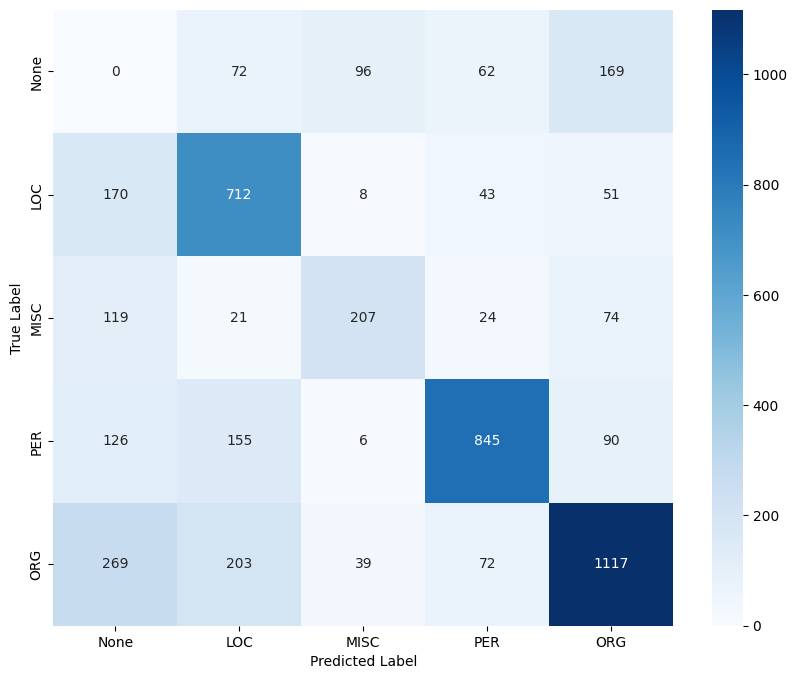

Resultados de Evaluación:
Recall: 0.6621, Precision: 0.7086, F1-Score: 0.6846

 ***************************************
   ENTRENAMENT MODEL: espanyol
   AMB ENCODING: io 

 ***************************************


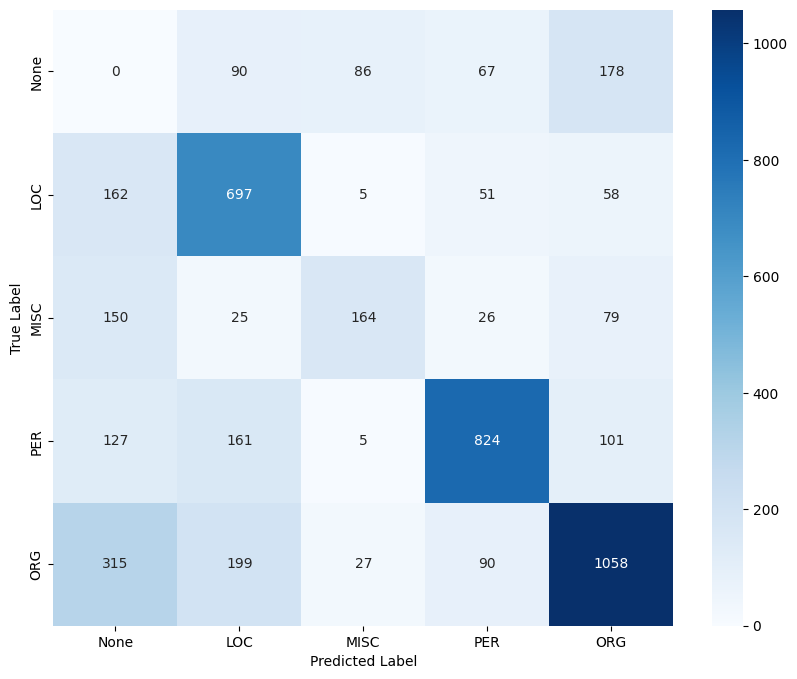

Resultados de Evaluación:
Recall: 0.6344, Precision: 0.6873, F1-Score: 0.6598

 ***************************************
   ENTRENAMENT MODEL: espanyol
   AMB ENCODING: bioes 

 ***************************************


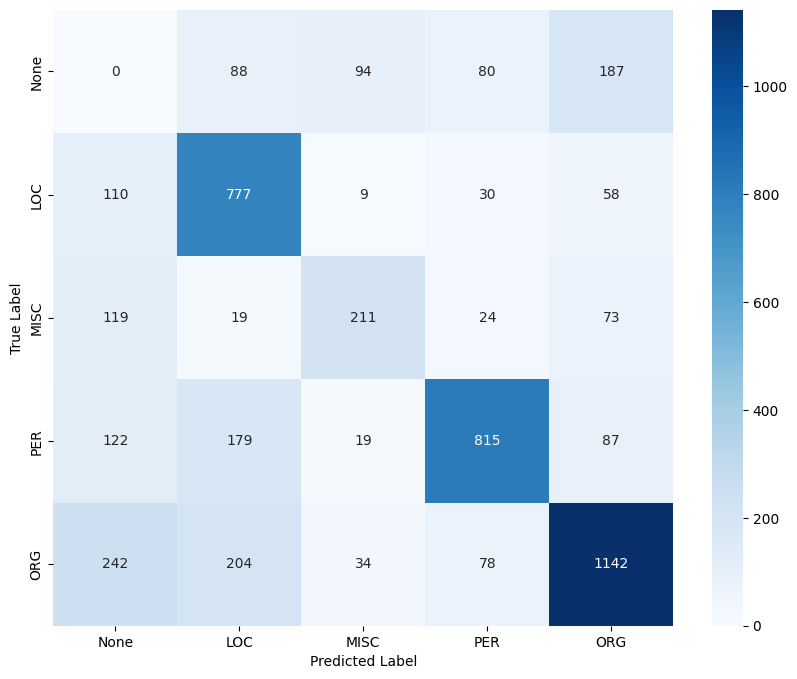

Resultados de Evaluación:
Recall: 0.6767, Precision: 0.6999, F1-Score: 0.6881

 PROCESSANT IDIOMA: neerlandes

 ***************************************
   ENTRENAMENT MODEL: neerlandes
   AMB ENCODING: bio 

 ***************************************


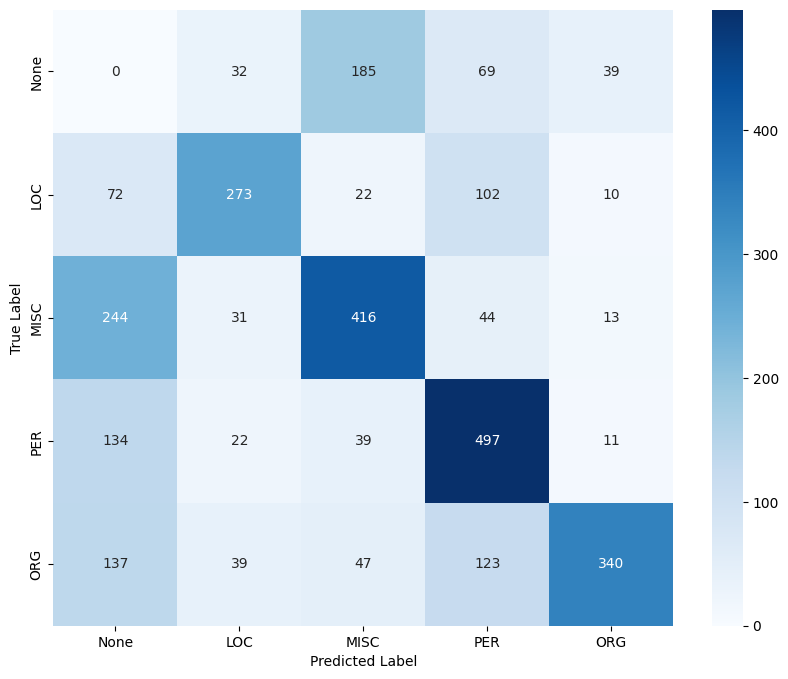

Resultados de Evaluación:
Recall: 0.5833, Precision: 0.6483, F1-Score: 0.6141

 ***************************************
   ENTRENAMENT MODEL: neerlandes
   AMB ENCODING: io 

 ***************************************


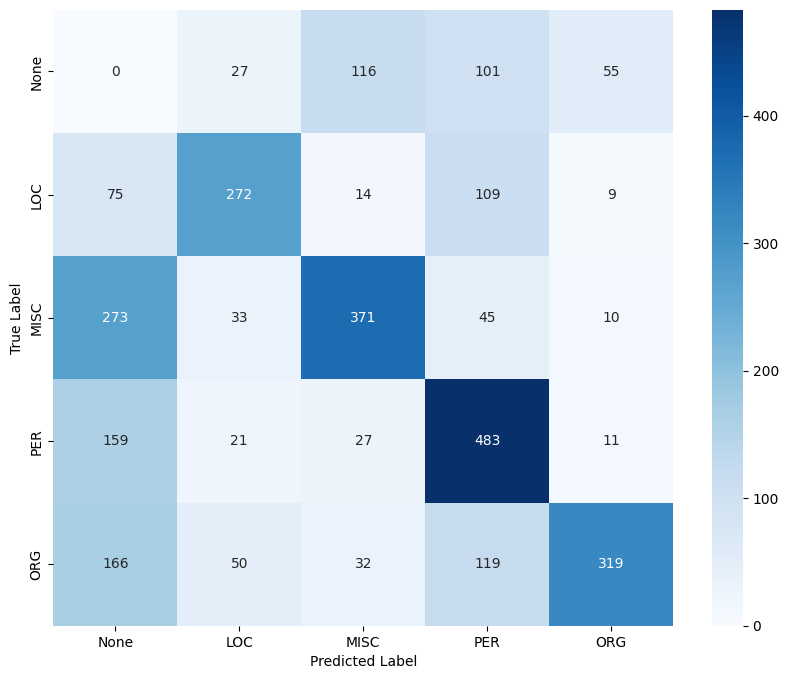

Resultados de Evaluación:
Recall: 0.5562, Precision: 0.6497, F1-Score: 0.5993

 ***************************************
   ENTRENAMENT MODEL: neerlandes
   AMB ENCODING: bioes 

 ***************************************


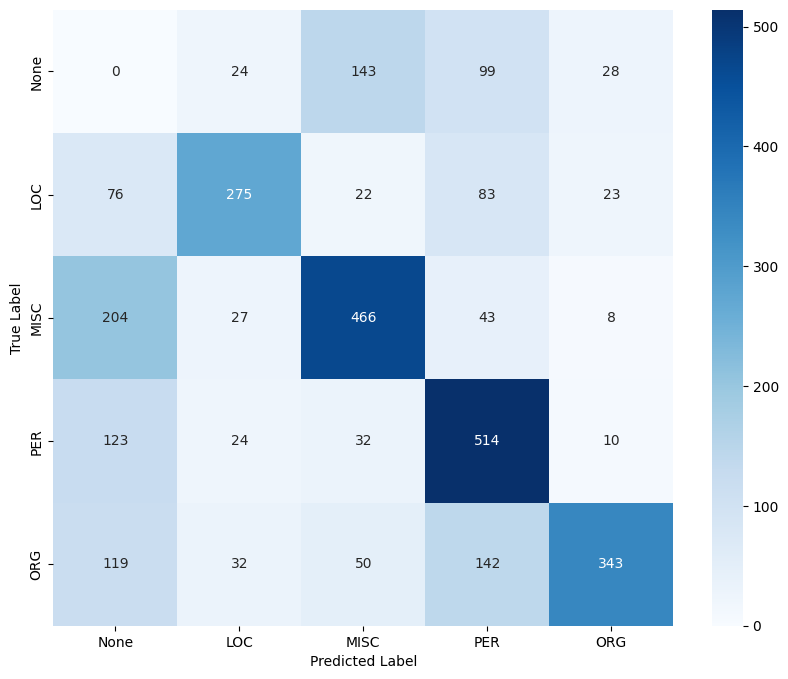

Resultados de Evaluación:
Recall: 0.6109, Precision: 0.6692, F1-Score: 0.6387


In [ ]:
languages_data = {
    'espanyol': {
        'train': conll2002.iob_sents('esp.train'),
        'val': conll2002.iob_sents('esp.testa'),
        'test': conll2002.iob_sents('esp.testb')
    },
    'neerlandes': {
        'train': conll2002.iob_sents('ned.train'),
        'val': conll2002.iob_sents('ned.testa'),
        'test': conll2002.iob_sents('ned.testb')
    }
}

for language, data in languages_data.items():
    print(f"\n PROCESSANT IDIOMA: {language}")

    train_data = [[(word, tag) for (word, _, tag) in sent] for sent in data['train']]
    val_data = [[(word, tag) for (word, _, tag) in sent] for sent in data['val']]
    entrenament_model(language, train_data, val_data, feature_function=None, tipus_encoding = ['bio', 'io', 'bioes'])


Un cop hem decidit quina combinació ens dona millors resultats per cada, fem les prediccions amb el test i avaluem els resultats.


 ***************************************
   ENTRENAMENT MODEL: espanyol_final
   AMB ENCODING: bioes 

 ***************************************


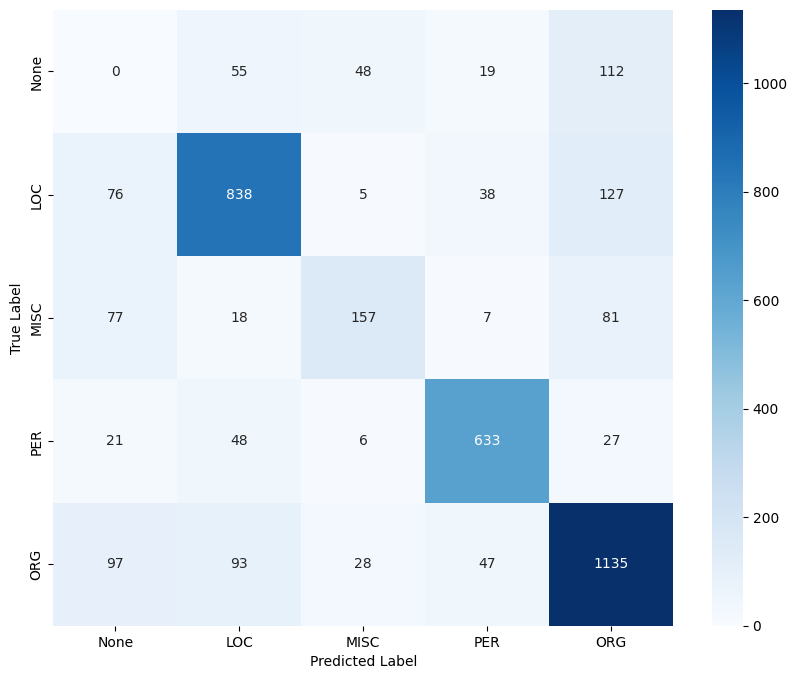

Resultados de Evaluación:
Recall: 0.7763, Precision: 0.7845, F1-Score: 0.7804

 ***************************************
   ENTRENAMENT MODEL: neerlandes_final
   AMB ENCODING: bioes 

 ***************************************


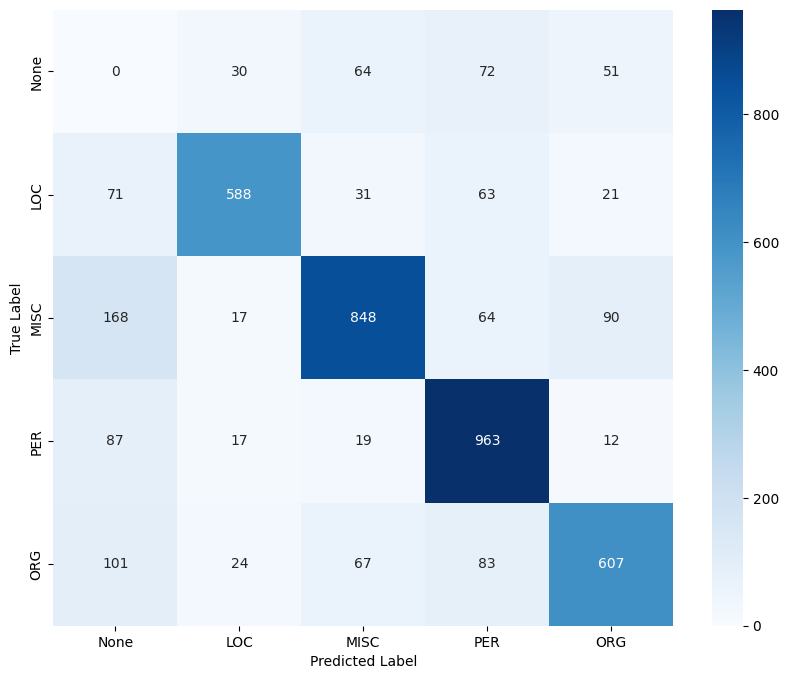

Resultados de Evaluación:
Recall: 0.7628, Precision: 0.8057, F1-Score: 0.7836


In [ ]:
def features_personalitzada(tokens, idx):
    """
    Funció que li proporcionarem a la classe del model
    Crea la nostra feature function a partir de
    les característiques decidides
    """
    feature_types = {
        'word_form': True,
        'lemma_pos_tags': False,
        'prefix_suffix': True,
        'morphology': True,
        'length': True,
        'position': True,
        'context': True
    }
    return creacio_feature_function(tokens, idx, feature_types)

#ESPANYOL
train_data = [[(word, tag) for (word, _, tag) in sent] for sent in languages_data['espanyol']['train']]
test_data = [[(word, tag) for (word, _, tag) in sent] for sent in languages_data['espanyol']['test']]
model_esp, f1_esp = entrenament_model(f"espanyol_final", train_data, test_data, feature_function=features_personalitzada, tipus_encoding = ['bioes'])

#NEERLANDÈS
train_data = [[(word, tag) for (word, _, tag) in sent] for sent in languages_data['neerlandes']['train']]
test_data = [[(word, tag) for (word, _, tag) in sent] for sent in languages_data['neerlandes']['test']]
model_ner, f1_ner = entrenament_model(f"neerlandes_final", train_data, test_data, feature_function=features_personalitzada, tipus_encoding = ['bioes'])

## AVALUACIÓ AMB TEXTOS REALS


 ***************************************
   ENTRENAMENT MODEL: text_real_espanyol
   AMB ENCODING: bioes 

 ***************************************


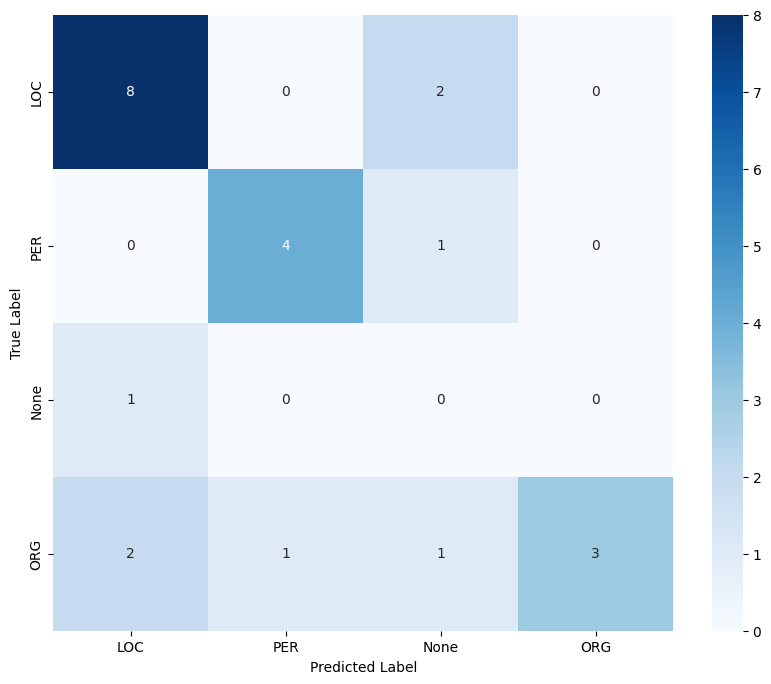

Resultados de Evaluación:
Recall: 0.6818, Precision: 0.7895, F1-Score: 0.7317

 ***************************************
   ENTRENAMENT MODEL: text_real_neerlandes
   AMB ENCODING: bioes 

 ***************************************


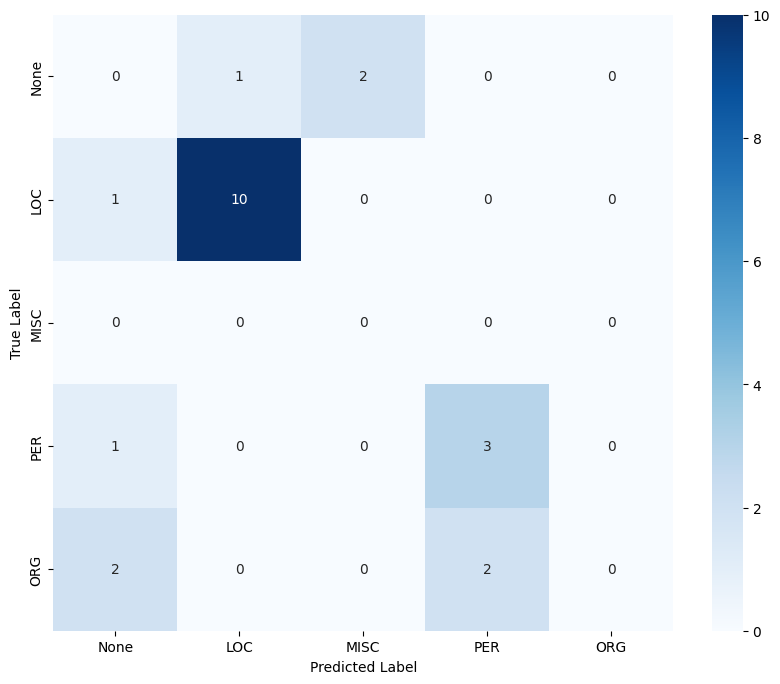

Resultados de Evaluación:
Recall: 0.6842, Precision: 0.7222, F1-Score: 0.7027


(<__main__.CRFModel at 0x781029527190>, 0.7027027027027027)

In [ ]:
#FRASES EN ESPANYOL
train_data = [[(word, tag) for (word, _, tag) in sent] for sent in languages_data['espanyol']['train']]
frases_esp = [
    [('Juan', 'B-PER'), ('Pérez', 'I-PER'), ('que', 'O'), ('trabaja', 'O'), ('para', 'O'), ('Microsoft', 'B-ORG'), ('viajará', 'O'), ('mañana', 'O'), ('a', 'O'), ('Barcelona', 'B-LOC')],
    [('Angela', 'B-PER'), ('Merkel', 'I-PER'), ('se', 'O'), ('reunió', 'O'), ('en', 'O'), ('Berlín', 'B-LOC'), ('con', 'O'), ('líderes', 'O'), ('de', 'O'), ('la', 'O'), ('Unión', 'B-ORG'), ('Europea', 'I-ORG')],
    [('El', 'O'), ('Museo', 'B-ORG'), ('del', 'I-ORG'), ('Prado', 'I-ORG'), ('es', 'O'), ('uno', 'O'), ('de', 'O'), ('los', 'O'), ('más', 'O'), ('famosos', 'O'), ('de', 'O'), ('España', 'B-LOC')],
    [('IBM', 'B-ORG'), ('presentó', 'O'), ('un', 'O'), ('nuevo', 'O'), ('proyecto', 'O'), ('en', 'O'), ('la', 'O'), ('ciudad', 'O'), ('de', 'O'), ('Nueva', 'B-LOC'), ('York', 'I-LOC')],
    [('Amazon', 'B-ORG'), ('ha', 'O'), ('establecido', 'O'), ('nuevas', 'O'), ('oficinas', 'O'), ('en', 'O'), ('Tokio', 'B-LOC')],
    [('El', 'B-LOC'), ('Cairo', 'I-LOC'), ('es', 'O'), ('la', 'O'), ('capital', 'O'), ('de', 'O'), ('Egipto', 'B-LOC'), ('y', 'O'), ('es', 'O'), ('conocida', 'O'), ('por', 'O'), ('sus', 'O'), ('pirámides', 'O')],
    [('Tim', 'B-PER'), ('Cook', 'I-PER'), ('presentará', 'O'), ('el', 'O'), ('nuevo', 'O'), ('iPhone', 'O'), ('en', 'O'), ('el', 'O'), ('evento', 'O'), ('anual', 'O'), ('de', 'O'), ('Apple', 'B-ORG')],
    [('Shakira', 'B-PER'), ('ofrecerá', 'O'), ('un', 'O'), ('concierto', 'O'), ('en', 'O'), ('Miami', 'B-LOC'), ('el', 'O'), ('próximo', 'O'), ('mes', 'O')],
    [('Harvard', 'B-ORG'), ('University', 'I-ORG'), ('es', 'O'), ('considerada', 'O'), ('una', 'O'), ('de', 'O'), ('las', 'O'), ('mejores', 'O'), ('del', 'O'), ('mundo', 'O')],
    [('Lionel', 'B-PER'), ('Messi', 'I-PER'), ('es', 'O'), ('un', 'O'), ('famoso', 'O'), ('futbolista', 'O'), ('nacido', 'O'), ('en', 'O'), ('Rosario', 'B-LOC'), ('Argentina', 'B-LOC')]
]
entrenament_model('text_real_espanyol', train_data, frases_esp, feature_function=features_personalitzada, tipus_encoding = ['bioes'])

#FRASES EN NEERLANDES

train_data = [[(word, tag) for (word, _, tag) in sent] for sent in languages_data['neerlandes']['train']]
frases_ner = [
    [('Mark', 'B-PER'), ('Rutte', 'I-PER'), ('de', 'O'), ('Nederland', 'B-LOC'), ('is', 'O'), ('de', 'O'), ('premier', 'O'), ('van', 'O'), ('het', 'O'), ('land', 'O')],
    [('Amsterdam', 'B-LOC'), ('is', 'O'), ('de', 'O'), ('hoofdstad', 'O'), ('van', 'O'), ('Nederland', 'B-LOC')],
    [('Anne', 'B-PER'), ('Frank', 'I-PER'), ('schreef', 'O'), ('haar', 'O'), ('dagboek', 'O'), ('in', 'O'), ('Amsterdam', 'B-LOC'), ('tijdens', 'O'), ('de', 'O'), ('Tweede', 'O'), ('Wereldoorlog', 'O')],
    [('Shell', 'B-ORG'), ('heeft', 'O'), ('haar', 'O'), ('hoofdkantoor', 'O'), ('in', 'O'), ('Den', 'B-LOC'), ('Haag', 'I-LOC')],
    [('Philips', 'B-ORG'), ('is', 'O'), ('een', 'O'), ('bekend', 'O'), ('bedrijf', 'O'), ('gevestigd', 'O'), ('in', 'O'), ('Eindhoven', 'B-LOC')],
    [('Rotterdam', 'B-LOC'), ('staat', 'O'), ('bekend', 'O'), ('om', 'O'), ('zijn', 'O'), ('moderne', 'O'), ('architectuur', 'O')],
    [('Arjen', 'B-PER'), ('Robben', 'I-PER'), ('speelde', 'O'), ('voor', 'O'), ('Bayern', 'B-ORG'), ('München', 'I-ORG'), ('en', 'O'), ('het', 'O'), ('nationale', 'O'), ('team', 'O'), ('van', 'O'), ('Nederland', 'B-LOC')],
    [('Utrecht', 'B-LOC'), ('is', 'O'), ('een', 'O'), ('oude', 'O'), ('stad', 'O'), ('in', 'O'), ('het', 'O'), ('hart', 'O'), ('van', 'O'), ('Nederland', 'B-LOC')],
    [('Koning', 'B-PER'), ('Willem-Alexander', 'I-PER'), ('is', 'O'), ('de', 'O'), ('monarch', 'O'), ('van', 'O'), ('Nederland', 'B-LOC')],
    [('De', 'O'), ('Universiteit', 'B-ORG'), ('van', 'I-ORG'), ('Amsterdam', 'I-ORG'), ('biedt', 'O'), ('veel', 'O'), ('verschillende', 'O'), ('opleidingen', 'O'), ('aan', 'O')]
]
entrenament_model('text_real_neerlandes', train_data, frases_ner, feature_function=features_personalitzada, tipus_encoding = ['bioes'])

# 2. Apartat opcional

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
tipos_de_entidad = ['ADR', 'Di', 'Dr', 'S', 'F']

def carregar_dataset_opcional(filepath):
    """
    Funció que llegeix i transforma les dades del dataset de l'apartat opcional
    en el format BIO correcte per introduir-la al nostre model
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        current_sent = []
        for line in file:
            line = line.strip()
            if not line:
                if current_sent:
                    data.append(current_sent)
                    current_sent = []
            else:
                parts = line.split()
                word = parts[0]
                tags = parts[1:]
                chosen_tag = 'O'
                for i, tag in enumerate(tags):
                    if tag != 'O':
                        tag_type = tag.split('-')[0]
                        tipo_entidad = tipos_de_entidad[i]
                        chosen_tag = f"{tag_type}-{tipo_entidad}"
                        break
                current_sent.append((word, chosen_tag))
        if current_sent:
            data.append(current_sent)
    return data



 ***************************************
   ENTRENAMENT MODEL: optional_corpus
   AMB ENCODING: bioes 

 ***************************************


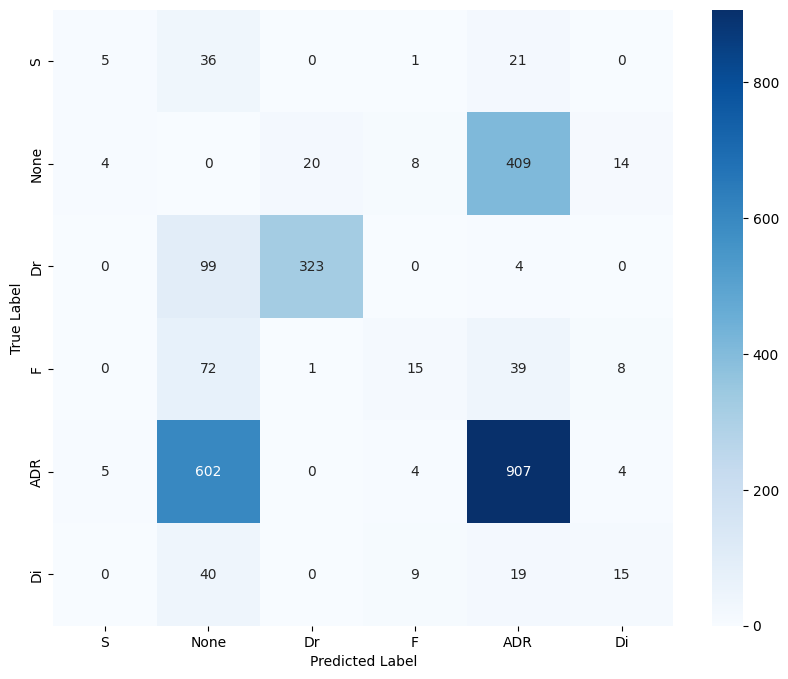

Resultados de Evaluación:
Recall: 0.5675, Precision: 0.6894, F1-Score: 0.6225


(<__main__.CRFModel at 0x781026fa8f40>, 0.6225393700787402)

In [42]:
#train_data = carregar_dataset_opcional('/content/drive/MyDrive/UNI/2n/Q4/3. Processament del Llenguatge Humà/PRÀCTIQUES/PRACTICA3-PLH/train.conll')
#test_data = carregar_dataset_opcional('/content/drive/MyDrive/UNI/2n/Q4/3. Processament del Llenguatge Humà/PRÀCTIQUES/PRACTICA3-PLH/test.conll')
train_data = carregar_dataset_opcional('/content/drive/MyDrive/train.conll')
test_data = carregar_dataset_opcional('/content/drive/MyDrive/test.conll')
entrenament_model('optional_corpus', train_data, test_data, feature_function=features_personalitzada, tipus_encoding= ['bioes'])